In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

def unique_col_values(df):
    l = []
    index = df.columns
    columns = ['Uniques', 'DT', 'Nulls (%)', 'Null Count']
    for column in index:
        u = len(df[column].unique())
        c = len(df[column])
        n = df[column].isnull().sum()
        l.append([u, df[column].dtype, n/c*100, n])
        
    return pd.DataFrame(l,index=index,columns=columns).sort_values(by='Nulls (%)', ascending=False)   

In [2]:
test = pd.read_csv('data/test.csv')
print(test.shape)
train = pd.read_csv('data/train.csv')
print(train.shape)
train.head()

(418, 11)
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


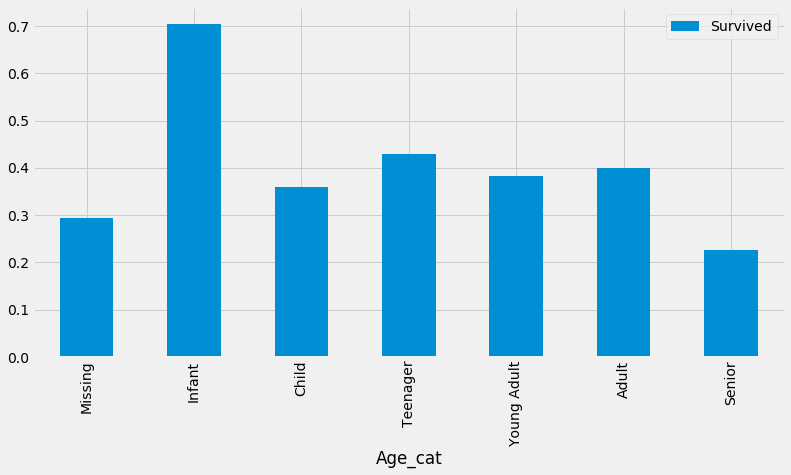

In [5]:
def process_age(df, cut_points, labels):
    df['Age'] = df['Age'].fillna(-1)
    df['Age_cat'] = pd.cut(df['Age'], cut_points, labels=labels)
    return df

cut_points = [-5,0,5,12,18,35,60,100]
labels = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train, cut_points, labels)
test = process_age(test, cut_points, labels)

pivot_age_cat = train.pivot_table(index='Age_cat', values='Survived')
pivot_age_cat.plot.bar()

In [6]:
def create_dummies(df, column):
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df,dummies],axis=1)
    return df

for c in ["Pclass","Sex","Age_cat"]:
    train = create_dummies(train,c)
    test = create_dummies(test,c)

In [8]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_cat_Missing','Age_cat_Infant',
       'Age_cat_Child', 'Age_cat_Teenager',
       'Age_cat_Young Adult', 'Age_cat_Adult',
       'Age_cat_Senior','Fare']

In [13]:
model = RandomForestRegressor(n_estimators=1000,
                             oob_score=True,
                             n_jobs=-1,
                             random_state=42,
                             max_features="auto",
                             min_samples_leaf=5)

model.fit(train[columns], train['Survived'])
roc = roc_auc_score(train['Survived'], model.oob_prediction_)
print("C-stat: ",roc)

C-stat:  0.849092981391


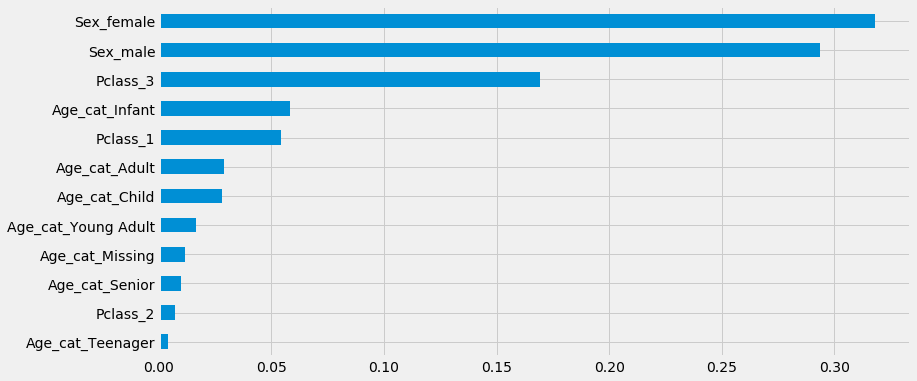

In [20]:
feature_importances = pd.Series(model.feature_importances_, index=train[columns].columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(12,6))

In [17]:
predictions = model.predict(test[columns])
submission_df = {'PassengerId':test['PassengerId'],
                 'Survived':predictions}
submission = pd.DataFrame(submission_df)
submission['Survived'] = submission['Survived'].round().astype(int)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [18]:
submission.to_csv('data/submission_rf2.csv',index=False)